In [71]:
# importing stuff
import tweepy
import numpy as np
import pandas as pd
import keys
import re
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.manifold import MDS
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances

<h1>Introduction</h1>

In this project, I used the contents of users' tweets to cluster the users by their similarities. Using the Twitter API, I got data about a user, including the content of their tweets. Then I used TF-IDF or term frequency-inverse document frequency to quantify how often users used various words. After quantifying their word choices and frequencies I could group various users by their similarities and differences using a clustering technique called K-means clustering.



In order to get data from the twitter API I had to create an app on the twitter development page, which gave me the credentials to make get requests to twitter. Below I'm authenticating to twitter and then creating an API object which I can use to make requests. (e.g user_time_line(), get_user(), etc.) 

In [29]:
consumerKey = keys.consumerKey
consumerKeySecret = keys.consumerKeySecret
AccessToken = keys.AccessToken
AccessTokenSecret = keys.AccessTokenSecret

#Authenticate to Twitter
auth = tweepy.OAuthHandler(consumerKey,consumerKeySecret)
auth.set_access_token(AccessToken, AccessTokenSecret)

# Create API object
api = tweepy.API(auth, wait_on_rate_limit=True)

# testing
try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


This method takes in a parameter text and "cleans" it. Most tweets contain lots of noise such as emojis, hashtags, referencing other users, and more. For any text this method removes the username, hashtage, urls, punctuation, numbers, stopwords (the, at, in, etc.), and stems the text (words like going -> go). What's left is the key words in each text that actually give us insights about the user.

In [30]:
def clean_text(text):
    cleaned_text = text

    # lower case 
    cleaned_text = " ".join([word.lower() for word in cleaned_text.split()])

    # remove username 
    cleaned_text = re.sub("@[^w\s]+"," ",cleaned_text)

    # remove hashtags 
    cleaned_text = re.sub("#[^w\s]+"," ",cleaned_text)

    # remove urls 
    cleaned_text = re.sub(r'http\S+', '', cleaned_text)

    # remove rt (for retweet)
    cleaned_text = re.sub("rt"," ",cleaned_text)

    # remove punctuation
    cleaned_text = re.sub('[^\w]',' ',cleaned_text)

    # remove numbers
    cleaned_text = re.sub("[\d-]"," ",cleaned_text)

    # stem
    stemmer = SnowballStemmer("english")
    cleaned_text = stemmer.stem(cleaned_text)

    # remove stop words 
    words = word_tokenize(cleaned_text)
    words = [word for word in words if not word in stopwords.words()]
    cleaned_text = " ".join(words)

    return cleaned_text 

clean_text("@bengardiner rand0m text #DS121 https://google.com more random text") #  --> rand text random text'

'rand text random text'

<h1> Data</h1>

The following code gets 30 twitter users than I am following, and it collects 100 of their most recent tweets. From these 100 tweets for all 30 users, I get the text from each tweet and "clean" it using the clean_text method. Leaving a large dataset where the columns represent the user and the rows represent the cleaned contents of one of their tweets. 

In [39]:
my_user_id = api.get_user(screen_name="bengardiner2021").id
following = api.get_friends(user_id=my_user_id,count=30)

data = []
names = []
for person in following:

    name = person.name
    id = person.id

    timeline = api.user_timeline(user_id=id, count = 100) # timeline of tweets 
    tweet_texts = [clean_text(t.text) for t in timeline]

    names.append(name)
    print(name)
    data.append(tweet_texts)

data = np.array(data).T # rotating data so tweet t aligns with column user name 
df = pd.DataFrame(data,columns=names)
df


    


Kevin Hart
NPR
Steve Harvey
Jim Cramer
Jimmy Kimmel Live
CNBC
Mike Pence
New York Post
The Guardian
BBC Breaking News
ABC News
HuffPost
Forbes
ashton kutcher
TIME
WIRED
SZA
Kim Kardashian
Rihanna
Marvel Studios
Boris Johnson
Hugh Jackman
Stephen Colbert
NAACP
Leader McConnell
The Tonight Show
International Space Station
Cristiano Ronaldo
Seth Rogen
Nancy Pelosi


,Kevin Hart,NPR,Steve Harvey,Jim Cramer,Jimmy Kimmel Live,CNBC,Mike Pence,New York Post,The Guardian,BBC Breaking News,...,Boris Johnson,Hugh Jackman,Stephen Colbert,NAACP,Leader McConnell,The Tonight Show,International Space Station,Cristiano Ronaldo,Seth Rogen,Nancy Pelosi
0,wooooow,russian energy giant decision cut gas expo pol...,mercy goes roast mode something might fun like...,trade,terrific ten,finally heading back office feel pressured rep...,supreme cou save religious libe football coach...,texas seeks block biden rule allowing border o...,cristiano ronaldo pegs chelsea back keep unite...,us president biden proposes record bn aid pack...,...,fantastic campaigning councillors west work ti...,every child,always trust eric nd instincts see fate honora...,bottom line black community accumulated debt g...,honored meet today sviatlana tsikhanouskaya le...,tonight amp perform forget love studio b,station new robotic arm released restraints na...,thanks suppo old trafford tonight always fans ...,poster amaz,join ambassador ukraine capitol unveil photo e...
1,laughs days,ramadan holiest month islamic calendar might k...,went sleeping car dollars longest running host...,put us,ohio senate race heating hypocrisy,house capitol riot probe seeks testimony key g...,freedom loving american follow join fight cons...,nursing home covid victim sues cuomo derosa wr...,number inactive adults england rises since covid,british national killed ukraine second missing...,...,second month row hit record numbers nhs staff ...,sunday eve new saturday night notice,tweets self driving,,far left waging national anti police anti law ...,get popcorn ready great show tonight christina...,spacewalker oleg emyev jettisoned thermal blan...,,witta movie real,today every day congress country remain ironcl...
2,time starring wahlberg amp hitting august th wait,fda proposing ban menthol flavored cigarettes ...,hate pharmacist yell prescription ready,ryan pick,mypillow mike lindell seems fixated jimmy,investing club qualcomm ceo says chipmaker aut...,new episode episode american freedom sits wtgi...,beat jennifer aniston liz hurley hottest woman...,vanessa denza obituary,charged murders four family members stabbed de...,...,promising statistics show knife crime neighbou...,lest forget chatswood near first home,yep tested positive covid basically feeling fi...,,biden administration approach border failing a...,chef daniel humm explains mission eleven madis...,two roscosmos spacewalkers began spacewalk tod...,,wild throw right handed trim left handed,yesterday house passed new legislation seize a...
3,,disney says florida pledged protect reedy cree...,behind every moment adversity lesson blessing ...,stock draft time,tonight,listen big day tech earnings apple amazon inte...,special edition hear freedom loving leaders co,aidan hutchinson family lives vegas nfl draft,ought shocked michael winterbottom unflinching...,dj tim westwood steps capital xtra show follow...,...,good discussions swiss president today welcome...,acknowledge call raise happy weekend,european fans happy,alarming reality communities,hea broken learn chabad house louisville cente...,president biden seriously considering student ...,narrated animation depicts tasks spacewalkers ...,tricks tricks time unbalance scale,get,house working every front suppo ukraine today ...
4,posted photo,icymi talks storytelling,already know crazy anthony anderson momma stev...,alphabet coming right back,make sure tune tonight see performance jimmy k...,investing club eli lilly strong qua promising ...,tomorrow wtgingrich walker miss,dow jumps points rebound tech stocks,captivating new tv series searches drive survi...,government policies discharging patients hospi...,...,𝗝𝗨𝗦𝗧 𝗜𝗡 police recruited police forces backed ...,millionth meal absolutely amazing thank join c...,mta says riders still wear masks pants still o...,first time sued treatment youth federal,deeply saddened learn passing friend former co...,nothing i

<h1> Methodology </h1>

From our dataset containing tweet texts, I decided to use the TF-IDF vectorizer to turn our lists of tweet contents into a matrix. For every word in the dataset we can see how often the user uses it with respect to the words overall popularity. For example, Kevin Hart's information is shown below; he seemed to use the words tickets, presale, posted, kevin, and photo a lot. Understanding that there was still a lot of noise in the data matrix I decided the use SVD and analyse the principal components of the matrix to see if I could reduce it. Using PCA, which centers the data and approximates it to a lower rank, we are given a smaller and slightly more managable matrix that still contained useful information. 

tickets    0.309236
presale    0.298231
posted     0.290079
kevin      0.242971
photo      0.234422
             ...   
found      0.000000
fought     0.000000
fou        0.000000
foster     0.000000
𝘃𝗶𝗯𝗲𝘀      0.000000
Name: Kevin Hart, Length: 7355, dtype: float64

X shape: (30, 7355)
reduced X shape: (30, 5)


C:\Users\benga\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


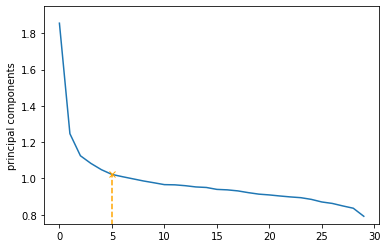

In [57]:
texts = []
for i in range(len(names)):
    name = names[i]
    tweets_text = data[:,i]
    text = " ".join(tweets_text)
    texts.append(text)

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts).todense()

u,s,vh = np.linalg.svd(X)

# graphing principal components
plt.plot(s)
plt.plot([5,5],[0,s[5]], "--",c="orange")
plt.plot(5,s[5],"x",c="orange")
plt.ylim(bottom=0.75)
plt.ylabel("principal components")

# svd = TruncatedSVD()
# red_X = svd.fit_transform(X)
pca = PCA(5) 
red_X = pca.fit_transform(X)


X_df = pd.DataFrame(X,columns=vectorizer.get_feature_names_out(), index=names).T
X_df

print(X_df["Kevin Hart"].sort_values(ascending=False)) # shows the most used words for kevin hart
print()
print("X shape:",X.shape)
print("reduced X shape:",red_X.shape)


<h1> Methodology (Continued) </h1>

For our clustering algorithm I decided to use KMeans because it is simple, and since we used it in class. In deciding how many clusters to use, I compared the silhouette score with the number of clusters. Looking at the graph, it's clear that 6 clusters has the highest score, so that is the number of clusters I decided to pick

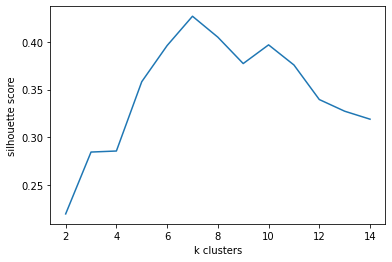

In [61]:
def kmeans(k):
    km = KMeans(k)
    km.fit(red_X)
    labels = km.predict(red_X)
    score = silhouette_score(red_X,labels)
    scores.append(score)

    return labels

scores = []
for i in np.arange(2,15):
    kmeans(i)

plt.plot(np.arange(2,15),scores)
plt.xlabel("k clusters")
plt.ylabel("silhouette score")

labels = kmeans(7)
clustered = pd.DataFrame(
    [names,labels]
).T


<h1> Analysis </h1>

Below I've printed the clusters using the hyperparameters selected above. Overall, it seems like the clusters are relatively accurate in clustering similar twitter users. One cluster contains many news sources (NPR, TIME, New York Post, etc.), another cluster contains comedians and entertainment users (Jimmy Kimmel, Stephen Colbert, the Tonight show, etc.), another contains politicians or political organizations (Nancy Pelosi, Mike Pence, Leader McConnell etc.), and another groups british users (Boris Johnson, BBC breaking news, the Guardian).


In [73]:
# prints the user names in each label group
for label in np.unique(clustered.iloc[:,1]):
    df = clustered.where(clustered[1] == label).dropna()
    print(df)
    print()


                   0  1
6         Mike Pence  0
24  Leader McConnell  0
29      Nancy Pelosi  0

                    0  1
0          Kevin Hart  1
2        Steve Harvey  1
13     ashton kutcher  1
15              WIRED  1
16                SZA  1
18            Rihanna  1
27  Cristiano Ronaldo  1
28         Seth Rogen  1

                0  1
3      Jim Cramer  2
5            CNBC  2
7   New York Post  2
12         Forbes  2

                    0  1
8        The Guardian  3
9   BBC Breaking News  3
20      Boris Johnson  3

                    0  1
4   Jimmy Kimmel Live  4
17     Kim Kardashian  4
21       Hugh Jackman  4
22    Stephen Colbert  4
25   The Tonight Show  4

           0  1
1        NPR  5
10  ABC News  5
11  HuffPost  5
14      TIME  5
23     NAACP  5

                              0  1
19               Marvel Studios  6
26  International Space Station  6



<h1> Conclusion </h1>

Overall, the clustering did a pretty good job at grouping together twitter users. While the score is still quite low, it still does a relatively good job of grouping together similar users. There are some issues however. Most real tweets on twitter are either advertisements from bots or simply random useless texts. If this project was used for many more random users, instead of a small sample of relatively similar and popular twitter accounts, it might struggle. Also, getting all the tweet information from the users takes a long time, so the data collection process isn't very effecient for getting lots of tweets from lots of users. 

<h1> References </h1>

information regarding connecting to the twitter api 
from - https://realpython.com/twitter-bot-python-tweepy/ 

information regarding cleaning twitter tweets 
from - https://towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529e 

information regarding PCA, TF-IDF vectorizer, kmeans, and more
from - Mayank Varia's DS121 lecture slides 